In [1]:
import numpy as np
import math
from skimage import io, util
import heapq
import sklearn
import Edmon

In [4]:
def randomPatch(orgImage, patchLength,initialCut = False):
    h, w, _ = orgImage.shape
   
    np.random.seed(1111)
    i = np.random.randint(h - patchLength)
    j = np.random.randint(w - patchLength)

    return orgImage[i:i+patchLength, j:j+patchLength]

In [5]:
def randomBestPatch(orgImage, patchLength, overlap, res, y, x):
    
    h, w, _ = orgImage.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            patch = orgImage[i:i+patchLength, j:j+patchLength]
            e = getErrorWithSelection(patch, patchLength, overlap, res, y, x)
            errors[i, j] = e

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return orgImage[i:i+patchLength, j:j+patchLength]

In [6]:
def getErrorWithSelection(patch, patchLength, overlap, res, y, x):
    error = 0

    if x > 0:
        left = patch[:, :overlap] - res[y:y+patchLength, x:x+overlap]
        error += np.sum(left**2)

    if y > 0:
        up   = patch[:overlap, :] - res[y:y+overlap, x:x+patchLength]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)

    return error

In [7]:
import matplotlib.pyplot as plt2
def minCutPatch(patch, patchLength, overlap, res, y, x,orgImage,imageName,fileCounter,showGraphCuts):

    patch_copy = patch.copy()
    res_copy = res.copy()
    overlapPatchCopy = patch.copy()
    totalNodes = 0
    if x > 0:
        #print("Trying a vertical cut",x,y)
        rightOfRes = res_copy[y:y+patchLength,x:x+overlap]
        leftOfPatch = patch_copy[:,:overlap]
      
        totalNodes = (len(rightOfRes) * len(rightOfRes[0]))+2
        
        #initiating the adj matrix
        matrix = []
        for i in range(0,(len(rightOfRes) * len(rightOfRes[0]))+2):
            rows = []
            for j in range(0,(len(rightOfRes) * len(rightOfRes[0]))+2):
                rows.append(0)
            matrix.append(rows)

        #assigning infinities

        for i in range(1,len(rightOfRes)+1):
            #print("Assigning inf from 0",i)
            matrix[0][i] = float('inf')
        for i in range(25*(overlap-1)+1,totalNodes-1):
            #print("Assigning inf from ",i,totalNodes-1)
            matrix[i][totalNodes-1] = float('inf')



        cols = len(rightOfRes)
        for i in range(1,patchLength+1):
            prev = i
            for j in range(0,overlap):
                if(j+1<overlap):                    
                    matrix[prev][prev+cols] = abs(getAvg(leftOfPatch[i-1][j]) - getAvg(rightOfRes[i-1][j])) + abs(getAvg(leftOfPatch[i-1][j+1]) - getAvg(rightOfRes[i-1][j+1]))+0.5

                if(i < patchLength):
                   
                    matrix[prev][prev+1] = abs(getAvg(leftOfPatch[i-1][j]) - getAvg(rightOfRes[i-1][j])) + abs(getAvg(leftOfPatch[i][j]) - getAvg(rightOfRes[i][j]))+0.5
                prev = prev+cols

        
        fileStr ='Adjancency Matrixs/'+(str)(imageName)+(str)(fileCounter)+"_Vertical"+"_EdmansKarp"+".txt"
        with open(fileStr, 'w') as f:
            for i in range(0,len(matrix)):
                for j in range(0,len(matrix[0])):
                    f.write(str(matrix[i][j]))
                    f.write(" ")
                f.write("\n")
        
        g = Edmon.EdmonKarps(matrix)
        #print("G",g)
        source = 0; sink = totalNodes-1
        #print("Got here",g.hello())
        left_pixels ,right_pixels,visited = g.minCut(source, sink)

        indexCounter = 1
        for i in range(0,overlap):
            for j in range(0,patchLength):
                
                if visited[indexCounter] == True:
#                     print("Found True at",indexCounter)
#                     print("Placing position",i,j)
                    patch_copy[j][i] = leftOfPatch[j][i]
                    overlapPatchCopy[j][i] = [255,0,0]
                indexCounter+=1
        
        #print("Final Index Counter",indexCounter)
                
        if showGraphCuts == True:
            
            ctr = 1
            minCutMatrix = []
            for i in range(0,patchLength):
                colorsRow = []
                for j in range(0,overlap):
                        colorsRow.append(2)
                minCutMatrix.append(colorsRow)

            for i in range(0,overlap):
                for j in range(0,patchLength):
                    if visited[ctr] == True:
                        minCutMatrix[j][i] = 1
                    ctr+=1

            fig, ax = plt.subplots()
            ax.matshow(minCutMatrix, cmap='ocean')
            plt.show()
        
    
    if y > 0:
#         print("Trying horizontal cut",x,y)
#         print("Cutting it from x-axis:",y,(y+overlap))
#         print("Cutting it from y-axis:",x,(x+patchLength))
        #lets define two sets
        matrix = []
        patch_up = res_copy[y:(y+overlap),x:x+patchLength]
        patch_bottom = patch_copy[:overlap,:]
        
#         print("PATCUP_",patch_up.shape)
#         print("PatchBottom",patch_bottom.shape)
        for i in range(0,(len(patch_up) * len(patch_up[0]))+2):
            rows = []
            for j in range(0,(len(patch_up) * len(patch_up[0]))+2):
                rows.append(0)
            matrix.append(rows)
        
        print(len(matrix),len(matrix[0]))
        #assigning infinities
        
        for i in range(0,patchLength):
            matrix[0][i] = float('inf')
        for i in range(totalNodes-1-patchLength,totalNodes-1):
            matrix[i][totalNodes-1] = float('inf')

        prev = 1
        for i in range(1,overlap+1):
            #print("I",i,i+patchLength)
            #prev = 1+(i-1)*patchLength
            for j in range(0,patchLength):
                #print("prev",prev)
                if(j<patchLength-1):
                    matrix[prev][prev+1] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i-1][j+1] - patch_bottom[i-1][j+1]))+0.5
                
                if(i<overlap):
                    matrix[prev][prev+patchLength] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i][j] - patch_bottom[i][j]))+0.5
                prev+=1

        #print(matrix)

        fileStr ='Adjancency Matrixs/'+(str)(imageName)+(str)(fileCounter)+"_Horizontal"+"_EdmanKarps"+".txt"
        with open(fileStr, 'w') as f:
            for i in range(0,len(matrix)):
                for j in range(0,len(matrix[0])):
                    f.write(str(matrix[i][j]))
                    f.write(" ")
                f.write("\n")

        g = Edmon.EdmonKarps(matrix)

        source = 0; sink = totalNodes-1

        left_pixels ,right_pixels,visited = g.minCut(source, sink)
        
#         print('Visited',len(visited))
        
        
        if showGraphCuts:
            
            ctr = 1
            #print("X",x)
            minCutMatrix = []
            for i in range(0,overlap):
                colorsRow = []
                for j in range(0,patchLength):
                        colorsRow.append(2)
                minCutMatrix.append(colorsRow)

            for i in range(0,overlap):
                for j in range(0,patchLength):
                    if visited[ctr] == True:
                        minCutMatrix[i][j] = 1
                    ctr+=1

            fig, ax = plt.subplots()
            ax.matshow(minCutMatrix, cmap='ocean')
    #         imageStr ='GraphCutImages/'+(str)(imageName)+(str)(fileCounter)+"_Horizontal"+"_EdmansKarp"+".png"
    #         fig.savefig(imageStr)
    #         plt.close(imageStr)
            plt.show()
        
        indexCtr = 1
        for i in range(0,overlap):
            for j in range(0,patchLength):
                if visited[indexCtr] == True:
                    patch_copy[i][j] = patch_up[i][j]
                    overlapPatchCopy[i][j] = [255,0,0]
                indexCtr+=1
                
    #print("Returning size of patchCopy",patch_copy.shape)

    return patch_copy,overlapPatchCopy

In [8]:
successfulPatch = []

In [9]:
def quilt(orgImage, patchLength, numPatches, mode, imageName,sequence=False,showGraphCuts = False):
    orgImage = util.img_as_float(orgImage)
    print(orgImage.shape)
    overlap = patchLength // 6
    #print("Overlapped region",overlap)
    numPatchesHigh, numPatchesWide = numPatches
    
    h = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    w = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap

    #print("height and width",h,w)
    #print("orgImage shape",orgImage.shape[2])
    
    res = np.zeros((h, w, orgImage.shape[2]))
    overlapImage = np.zeros((h, w, orgImage.shape[2]))
    #print("Res",res.shape)
    
    counter = 1
    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)
#             print("X",x)
#             print("Y",y)
            if i == 0 and j == 0 or mode == "random":
                patch = randomPatch(orgImage, patchLength)
                successfulPatch = patch
                overlapPatch = patch
            elif mode == "best":
                patch = randomBestPatch(orgImage, patchLength, overlap, res, y, x)
            elif mode == "cut":
                patch = randomBestPatch(orgImage, patchLength, overlap, res, y, x)
                patch,overlapPatch = minCutPatch(patch, patchLength, overlap, res, y, x,orgImage,imageName,counter,showGraphCuts)
            
            res[y:y+patchLength,x:x+patchLength] = patch
            overlapImage[y:y+patchLength,x:x+patchLength] = overlapPatch

            if sequence:
                io.imshow(res)
                io.show()
            
            counter+=1
      
    return res,overlapImage

In [10]:
def getAvg(pixelArray):
    return (sum(pixelArray)/3)

(64, 64, 3)
(64, 64, 3)
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62
62 62


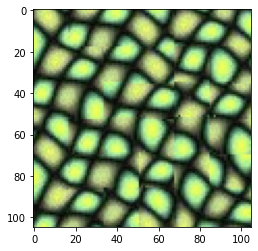

In [14]:
import cv2
import matplotlib.pyplot as plt2
img = cv2.imread('todo.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt2.imshow(img)
print(img.shape)
finalImage,overlapPlot = quilt(img, 20 , (6, 6), "cut",'todo',False,False)
plt2.imshow(finalImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


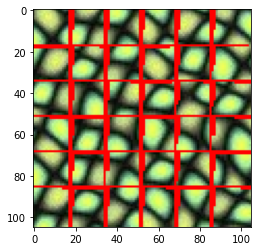

In [15]:
plt.imshow(overlapPlot)

(157, 237, 3)
(157, 237, 3)
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402
402 402


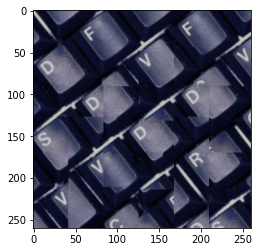

In [12]:
import cv2
import matplotlib.pyplot as plt
keyimg = cv2.imread('key.png')
keyimg = cv2.cvtColor(keyimg, cv2.COLOR_BGR2RGB)
plt.imshow(keyimg)
print(keyimg.shape)
keyimg,overlapImage = quilt(keyimg, 50, (6,6), "cut",False,False)
plt.imshow(keyimg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


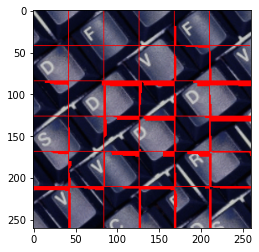

In [13]:
plt.imshow(overlapImage)

In [4]:
fileStr = 'Adjancency Matrixs/'+(str)("imageName")+(str)("fileCounter")+"_Horizontal"+"_FordFulkerson"+".txt"

In [183]:
import Hello

In [184]:
h = Hello.Hello()

In [185]:
h.hello2()

AttributeError: 'Hello' object has no attribute 'hello2'

In [182]:
h.hello()

Why not


1

In [15]:
import Edmon

In [16]:
e = Edmon.EdmonKarps([[1],[2]])

In [188]:
print(e.__dict__)

{'matrixAsGraph': [[1], [2]], 'org_matrixAsGraph': [[1], [2]], 'noOfRows': 2, 'noOfCols': 1}


In [17]:
dir(e)

['BFS',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dfs',
 'matrixAsGraph',
 'minCut',
 'noOfCols',
 'noOfRows',
 'org_matrixAsGraph']

In [ ]:
#To include in Readme
#In case of any attributes not found error in Edmons module, please restart the kernel so that the modules are reloaded